## Import dependencies

In [3]:
import mediapipe as mp
import numpy as np
import cv2 as cv2
import os
from matplotlib import pyplot as plt
import time

## Keypoints using MP Holistic

In [4]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [5]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [6]:
def draw_styled_landmarks(image,results):
    mp_drawing.draw_landmarks(image,results.face_landmarks,mp_holistic.FACEMESH_TESSELATION,
                             mp_drawing.DrawingSpec(color = (51,255,255), thickness=1, circle_radius=1),
                             mp_drawing.DrawingSpec(color = (153,0,76), thickness=1, circle_radius=2))
    mp_drawing.draw_landmarks(image,results.pose_landmarks,mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color = (51,102,0), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color = (102,78,255), thickness=2, circle_radius=2))
    mp_drawing.draw_landmarks(image,results.left_hand_landmarks,mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color = (102,0,204), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color = (255,255,102), thickness=2, circle_radius=2))
    mp_drawing.draw_landmarks(image,results.right_hand_landmarks,mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color = (102,0,204), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color = (255,255,102), thickness=2, circle_radius=2))

In [7]:
cap = cv2.VideoCapture(0);
with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5 ) as holistic:
    while cap.isOpened():
        ret,frame = cap.read()
        image, results = mediapipe_detection(frame,holistic)
#         print(results)
        draw_styled_landmarks(image,results)
        cv2.imshow('OpenCv Window',image)
        if cv2.waitKey(10) & 0xff == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [8]:
draw_styled_landmarks(frame,results) 

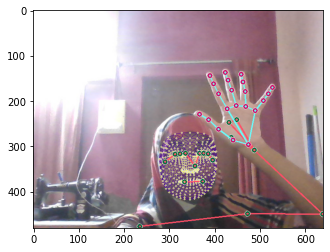

In [9]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

In [3]:
# img = cv2.imread("img.jpg")

NOSE world landmarks : 
x: 0.012576468288898468
y: -0.5454941987991333
z: -0.2534702718257904
visibility: 0.9999974966049194



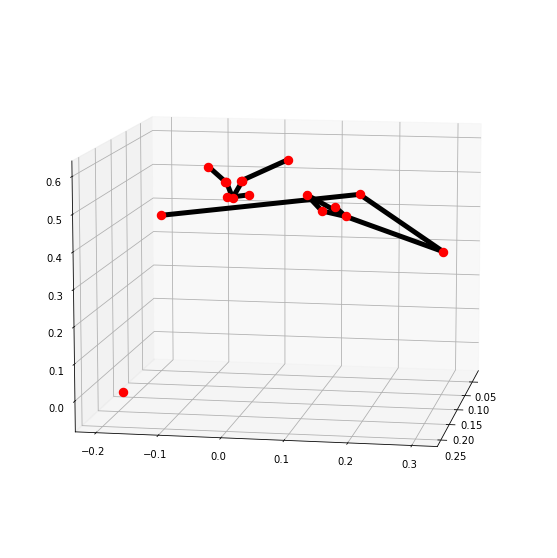

In [5]:
# with mp_holistic.Holistic(static_image_mode=True) as holistic :
#     result = holistic.process(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
#     print('NOSE world landmarks : ')
#     print(result.pose_world_landmarks.landmark[mp_holistic.PoseLandmark.NOSE])
    
# #     Plot pose world landmarks
#     mp_drawing.plot_landmarks(
#     result.pose_world_landmarks,mp_holistic.POSE_CONNECTIONS)

## Extract key value points

In [40]:
def extract_keypoints(results):
    pose = np.array([[res.x,res.y,res.z,res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(1404)
    face = np.array([[res.x,res.y,res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(63) 
    lh = np.array([[res.x,res.y,res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(63)
    rh = np.array([[res.x,res.y,res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(63) 
    return np.concatenate([pose,face,lh,rh])

In [48]:
result_test = extract_keypoints(results)

In [49]:
result_test

array([ 0.558689  ,  0.7163859 , -1.08938646, ...,  0.        ,
        0.        ,  0.        ])

132